### INE 410146 - Applied Machine Learning
$\textbf{Author: Prof. Mateus Grellert}$

Bibliography used in this lesson:
- Machine Learning: A Probabilistic Perspective, Kevin P. Murphy. Chapter 6.4
- Pattern Recognition and Machine Learning, Christopher M. Bishop. Chapter 3.2
- Aggarwal, Charu C. Data mining: the textbook. Springer, 2015 - Chapter 11.8


# 10 - Model selection

As we've already discussed in previous lessons, we can obtain several different models with the same data set, even when using the same algorithm. For newcomers, this may cause a bit of confusion, as there is no exact indication of which model or which configuration will perform better.

The truth is that we often need to test the different combinations of algorithms and their parameters in order to find a suitable option for each data in a process known as **model selection**. 

During model selection, we test different possibitilities of learning algorithms and their training parameters (which are called **hyperparameters**), looking for the one that will likely work best when deployed. An example of hyperparameter is **number of hidden layers** in a NN or the **activation function** used in each node. Each learning algorithm has its own set of hyperparameters, so studying their documentation is a necessary step in this process. We will more about this later in this lesson.

However, the fundamental question is still unanswered: *which model is better than all others?*

A naive answer to this question, which is often mistakingly considered to be true, is that the best model is the one with maximum performance (e.g., accuracy) on the training set. We will see in this lesson why this is a problem and also how we can avoid this issue.


## Underfitting and Overfitting

**Overfitting** is one of the greatest headaches for applied machine learning. It happens when models become too complex in order to maximize performance on the training and fail to grasp the actual structure of our data. 

To understand overfitting, let's take a real-life example where a teacher decides to give the class a test with 20 questions:
- Scenario A:
 - To ensure students will be prepared, the teacher provides 100 practicing exercises, saying that all the test questions will be drawn from these 100 exercises. 
 - In order to maximize their grades, the lazy students will simply memorize the answer of all 100 exercises instead of actually learning the subject. 
- Scenario B:
 - Now let's say the teacher takes a different approach and tells the students that the test will contain only questions that are different from the ones used in the exercises. 
 - In this case, students will need to actually learn the subject if they want to perform well on their test.
 
**Scenario A** represents an overfitting situation. Machine learning models are like lazy students in the sense that they are programmed to **minimize a loss function**. Therefore, they are prone to become more complex than necessary in order to achieve this, regardless of the fact that the final solution may not reflect the structure of the data being modeled.

Now let's think of a third scenario, in which only 5 questions are provided as exercise. In this case, students might not be able to exercise all of the subject and will likely perform poorly on the test. In this case, we have an **underfitting** scenario, which in machine learning translates to a model that is too simplistic and that might not be able to actually learn important aspects of our data. 

The figure below shows a pictorial example for a regression problem where different polynomials attempt to model the data, represented as blue points in the charts. The orange line denotes the actual function from which data was obtained. The MSE shown in each chart represents the difference between the model and the true function.

<center>
<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png" width="80%" /> <br> (source: Scikit-learn, Overfitting vs Underfitting - <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html">link</a>)
</center>

In the first plot, a linear function ($\mathrm{degree}=1$) is used, producing a large Mean Squared Error (MSE) of $4.08\mathrm{e-}01$. This is a typical case of underfitting. The last plot uses a much more complex polynomial (degree of $15$), leading to a model that almost perfectly passes through every data point. While this leads to a very small error in the training set, the MSE between this model and the true function is the highest of them all ($\mathrm{MSE}=1.81\mathrm{e+}08$). In this case, we have an overfitted model. Finally, the chart in the middle represents the best trade-off between model complexity and prediction error, using a 4th-degree polynomial.

Paraphrasing Bishop, the use o  training methods that aim at minimizing the loss function  can lead  to severe overfitting, specially if complex models are trained using data sets of limited size. However, limiting  the  complexity of the models  in  order  to  avoid  overfitting  has  the  side-effect of limiting the flexibility of the model to capture interesting and importanttrends in the data (causing underfitting). 

If we are working with separate data sets for training and testing (as we should), **underfitting** is detected when we have a **high loss (low performance) on both training and test sets**. In other words, our model will not even be able to memorize our data if it is underfitted.

**Overfitting** is detected when we have a **low loss on the training set** and a **high loss on the test set**. This is why overfitted models are often mistakingly advertised as efficient solutions, because they work really well with data that was previously seen. This is, however, extremely unethical and should never be practiced by anyone.

### Python Example

Now let's see an example in Python to consolidate these concepts, using an example obtained from the TWDS blog (<a href="https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765">link</a>). Let's start by creating a synthetic data set based on a sinusoidal series.


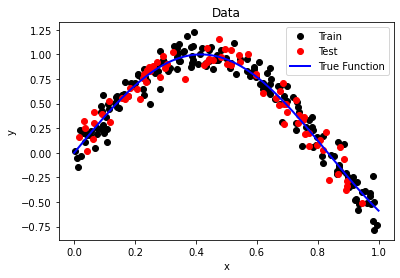

In [1]:
# code adapted from: https://github.com/WillKoehrsen/Data-Analysis/blob/master/over_vs_under/Over%20vs%20Under%20Fitting%20Example.ipynb

import numpy as np 
import matplotlib.pyplot as plt

# "True" generating function representing a process in real life
def true_gen(x):
    y = np.sin(1.2 * x * np.pi) 
    return(y)

# sort x values to generate a series-likr behavior 
x = np.sort(np.random.rand(250))
# create the sinusoidal signal and add some noise to it
y = true_gen(x) + 0.1 * np.random.randn(len(x))

# Random indices for creating training and testing sets
random_ind = np.random.choice(list(range(250)), size = 250, replace=False)
xt = x[random_ind]
yt = y[random_ind]

# Training and testing observations (70-30 split)
Xtr = xt[:int(0.7 * len(x))]
Xte = xt[int(0.7 * len(x)):]

ytr = yt[:int(0.7 * len(y))]
yte = yt[int(0.7 * len(y)):]

# Model the true curve
x_linspace = np.linspace(0, 1, 1000)
y_true = true_gen(x_linspace)

# Visualize observations and true curve
plt.plot(Xtr, ytr, 'ko', label = 'Train'); 
plt.plot(Xte, yte, 'ro', label = 'Test')
plt.plot(x_linspace, y_true, 'b-', linewidth = 2, label = 'True Function')
plt.legend()
plt.xlabel('x'); plt.ylabel('y'); plt.title('Data');


Now that we have our train and test data sets, we can create classifiers that will attempt at modeling their undelying structure (represented by the true function). We will use a simple polynomial fit instead of actual machine learning models. For that, we can count on the ``polyfit`` method of the ``numpy`` package. The ``poly1d`` method creates an actual function (model) that can be used with our test samples to make predictions. We will compare three approaches: a linear fit (1-degree polynomial), a polynomial with a degree of 5, and a third one with a degree of 30. 

In [2]:
from sklearn.linear_model import LinearRegression

# training/fitting 
# the third parameter of `polyfit` is the degree of the polynomial
poly1 = np.poly1d(np.polyfit(Xtr, ytr, 1))
poly5 = np.poly1d(np.polyfit(Xtr, ytr, 5))
poly30 = np.poly1d(np.polyfit(Xtr, ytr, 30))

# prediction/evaluation (train)
pred_linear = poly1(Xtr)
pred_poly5 = poly5(Xtr)
pred_poly30 = poly30(Xtr)

mse_linear_tr = np.sqrt((ytr - pred_linear )**2).mean()
mse_poly5_tr = np.sqrt((ytr - pred_poly5 )**2).mean()
mse_poly30_tr = np.sqrt((ytr - pred_poly30 )**2).mean()

# prediction/evaluation (test)
pred_linear = poly1(Xte)
pred_poly5 = poly5(Xte)
pred_poly30 = poly30(Xte)

mse_linear_te = np.sqrt((yte - pred_linear )**2).mean()
mse_poly5_te = np.sqrt((yte - pred_poly5 )**2).mean()
mse_poly30_te = np.sqrt((yte - pred_poly30 )**2).mean()

print('MSE(linear): train %.3f, test %.3f' % (mse_linear_tr, mse_linear_te))
print('MSE(poly5): train %.3f, test %.3f' % (mse_poly5_tr, mse_poly5_te))
print('MSE(poly30): train %.3f, test %.3f' % (mse_poly30_tr, mse_poly30_te))


MSE(linear): train 0.366, test 0.311
MSE(poly5): train 0.085, test 0.087
MSE(poly30): train 0.082, test 0.090


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Note that the highest MSE values occurred with the linear model, which makes sense because we are modeling a non-linear function (**underfitting**). When using a degree of 30, we obtain a much lower MSE in our training samples, but it increases when the test samples are used (**overfitting**). The option with a degree of 5 leads to almost the same MSE in the training set, while keeping a lower MSE in the test set as well (**good balance**).

We can also visualize these predictions in order to understand what's happening. Note that the higher-degree polynomial diverges when $x$ is close to $1$.

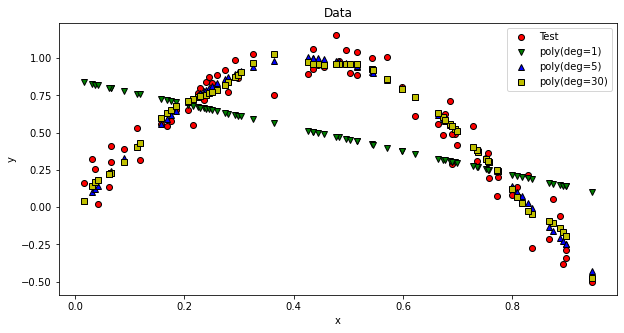

In [3]:
fig = plt.figure(figsize = (10,5))

plt.plot( Xte, yte, 'ro', label = 'Test',
         markeredgewidth=1, markeredgecolor='k')
plt.plot(Xte, pred_linear, 'gv', label = 'poly(deg=1)',
        markeredgewidth=1, markeredgecolor='k')
plt.plot(Xte, pred_poly5, 'b^', label = 'poly(deg=5)',
         markeredgewidth=1, markeredgecolor='k')
plt.plot(Xte, pred_poly30, 'ys', label = 'poly(deg=30)',
         markeredgewidth=1, markeredgecolor='k')

plt.legend()
plt.xlabel('x'); plt.ylabel('y'); plt.title('Data');


Now let's dive into the technical aspects surrounding the phenomenon of under and overfitting by introducing the bias-variance trade-off. We will lead the explanation using classification problems, but the same applies for regression as well.

## The Bias-Variance Trade-Off

The bias-variance trade-off is a concept that tries to understand how the error function of our classifiers work.

Let's start by stating that the expectation of a given loss function $L$ can be computed as follows:

$\mathbb{E}(L)=\mathrm(bias)^2+\mathrm(variance)+\mathrm(noise)$

The mathematical details of this decomposition are shown in Bishop's textbook, but we will try to keep things light and focus on its components. Now let's see how Aggarwal describes them in his textbook:

- **Bias:** every classifier makes its own modeling assumptions about the nature of the decision boundary between classes. This is, of course, not always true in practice. For instance, in some cases, no linear classifier can classify all the possible test instances correctly even if the best possible model is constructed with a very large training data set. In other words, any given linear model will have an inherent bias. When a classifier has **high bias**, it will make **consistently incorrect predictions** over particular choices of test instances near the incorrectly-modeled decision boundary, even when different samples of the training data are used for the learning process.

- **Variance:** random variations in the choices of the training data will lead to different models. Let's recall the picture with the polynomial fits we've discussed before. A polynomial with a high-enough degree can approximate even complex functions quite well. However, if we separate several subsets of the data points and use them to train different polynomials, we will have a large difference among the results. This is a manifestation of model variance. Model variance is closely related to overfitting. When a classifier has an overfitting tendency, it will make inconsistent predictions for the same test instance over different training data sets.

The bias comes from the mean error obtained **between the classifier predictions and the real data**, whereas the variance comes from the mean difference between **the predictions of different classifiers**, each trained with a different subset of our data. The picture below shows a very good illustration of bias and variance, considering that the correct answers lie within the red circle.

<center>
<img src="https://media-exp1.licdn.com/dms/image/C5612AQEaeiv-x6r0qg/article-inline_image-shrink_1500_2232/0/1536615163393?e=1648080000&v=beta&t=U3Hq75_v-aSCGKQd2X0C7Nubvo5F0Ot0WvCwiCZPN-4" width="70%"/> <br> (source: *Understanding the Bias-Variance Tradeoff* by Scott Formann)
</center>

We call it the **bias-variance trade-off**, because usually the following rules apply:
- Relatively **rigid** models have high bias and low variance.
- Very **flexible** models present low bias and high variance.
- The model with the optimal predictive capability is the one that leads to the best **balance** between bias and variance. 

We can also think of a relationship between these terms and the quality of our fit. Models with **high bias** usually represent cases of **underfitting**, whereas models with **high variance** are commonly associated with **overfitting**. The design choices considered in the model selection step have a direct impact in this trade-off. Simpler models are more prone to present high bias and low variance, whereas complex models will likely present low bias and high variance. 

The figure below shows another example of the bias-variance trade-off as a function of a **regularization parameter** $\lambda$ (which will be discussed later on), showing that there is an optimal point that minimizes loss near $\lambda=0.4$.  

<center>
    <img src="FIGS/10-bas_variance_tradeoff_chart.png" width="50%" />
        (source: Bishop, C. "Pattern Recognition and Machine Learning")

</center>

There is no easy way to figure out the best parameter or learning algorithm that will lead to the best result in the bias-variance trade-off, but knowing how we can identify and deal with these two components can help us come up with strategies to improve our models. We will see in the next sections some approaches that can be useful in many cases. 

## Detecting Underfitting and Overfitting

Assessing the quality of our fit is a bit tricky, because ideally we need to look at the test set in order to identify discrepancies. However, we also know that we should avoid using the test set in the model selection step.

A good alternative is to employ **cross-validation** (CV) or to use a separate **validation set** that comes from the training samples. This way, the samples used for evaluation are also part of the training set.

Regardless of which approach we are using, we can detect over/underfitting by comparing the train and validation loss. The idea is the following:

- Underfitting occurs when the train loss is low and the validation loss is also low (even if its higher than the train loss)
- Overfitting occurs when train loss is high and the validation loss is low.

In iterative optimization methods, such as **gradient descent**, it is common to plot the train vs validation loss after each iteration. Let's see the following examples below:

<center>
<div style="display: flex">
  <img src="https://machinelearningmastery.com/wp-content/uploads/2019/02/Example-of-Training-Learning-Curve-Showing-An-Underfit-Model-That-Does-Not-Have-Sufficient-Capacity.png" width="50%" />  
  <img src="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-An-Overfit-Model.png" width="50%" />  
</div>
     <img src="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-A-Good-Fit.png" width="60%" />  
    (source: Machine Learning Mastery - <a href="https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/">link</a>).
</center>

The $x$ axis of each plot represents the iterations through time. For instance, if the model being trained is a NN, it might represent the epochs or the batches being processed. The $y$ is the loss function. The two plots in the upper half represent **underfitting** (on the left) and **overfitting** (on the right). The plot in the lower half represents a good balance between train/validation losses, and should be pursued by practitioners. Note that this balance is usually obtained at the cost of a larger loss in training set, but this only means that we are not being tricked by overfitting.

## Dealing with Underfitting

Handling underfitting can be done in multiple ways. As we could see in the example above, a possible method is to increase the models parameters (and by extension its complexity). It is also possible to switch to a learning algorithm that supports complex relationships, like Neural Networks, instead of a linear logistic/regression model. 

Another approach consists in adding more training data, which can be done in two ways:
 - **Column-wise:** by creating new features from the current ones (also known as **Feature engineering**).
 - **Row-wise:** by getting more samples from the data source, or finding new data sources, or even by creating synthetic samples (used in some class-balancing techniques). 

Getting more data is always a good idea, but often not a possible one. It is not uncommon to find situations where a customer or project manager asks for a classification model with less than 50 samples for training, because getting more samples would violate time or budget restrictions. In such cases, resorting to simpler statistical approaches (correlation/association analysis, ANOVA etc) might be a better option.

## Dealing with Overfitting

One of the main goals of model selection is to obtain a model with good performance while reducing the chances of overfitting. Therefore, the techniques discussed in the following paragraphs should be included in the pipeline of any ML pracititioner (when applicable, of course).

### Hyperparameter Tuning

As we've briefly discussed in the beginning of this lesson, each learning algorithm has a set of parameters that can be tuned to produce different models, called hyperparameters. For instance, we can train a NN using a single hidden layer containing 50 nodes, but who's to say we wouldn't get better results with 100 or 25 nodes? The goal of hyperparameter tuning is to answer this question. 


<div style="background-color: cornsilk;padding: 5px; margin: 5px; border-style:solid; border-width:1px" >
    <strong>Note:</strong> hyperparameters are <strong>NOT</strong> to be confused with the parameters of the model. The former represents the training algorithm configurations, whereas the latter is used to express the model itself (for example, the weights in a neural network are commonly referred to as the parameters of this NN).
</div>

Now let's look at the steps of one of the most used strategies of hyperpameter tuning called **grid search CV**. It receives a dictionary with hyperparameters and the values that must be tested for each (*hyperparameter_dict*), the CV train and test sets (*cross_val_sets*), and the *classifier* being trained. Its output is the set of hyperparameters that minimize the average CV loss (*best_hyperparameters*).

<pre style="background-color: aliceblue;padding: 5px; border-style:solid; border-width:1px" >
<strong>Algorithm - Grid search CV </strong>
01. compute hyperparameter_sets with all combinations from hyperparameter_dict

02. for hyperparam_set in hyperparameter_sets:
03.  for (train_set, test_set) in cross_val_sets:
04.     train the classifier with train_set
05.     compute loss for test_set
06.  compute avg_cv_loss
07.  if avg_cv_loss  min_cv_loss:
08.     best_hyperparameters = param_set
09.     min_cv_loss = avg_cv_loss
     
10. return best_hyperparameters
</pre>

Notice that the complexity of the grid search CV is combinatorial with the number of hyperparameter sets that are considered. This is also one of the main problems of this approach. Most learning algorithms contain several hyperparameters, each with many possible values, so this number can easily grow to unfeasible proportions. 

Nonetheless, grid search is still widely adopted due to its simplicity and because it can be easily parallelized to multiple cores. 

Alternatives to the full grid search include:

- **Randomized grid search**: a great paper from Bergstra and Bengio (<a href="https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf">link</a>) shows that using randomized combinations of the hyperparameters can lead to the same results obtained with grid search within a small fraction of the computation time. The idea is that using a smaller subset of randomized hyperparameters allows greater exploration of unlikely values which can eventually lead to even better results than those of grid search. Randomized CV is included in ``scikit-learn`` (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html">link</a>).

- **Sequential model-based optimization (SMBO)**: the idea of this approach is to use a probability model called surrogate that tries to predict the improvements obtained with each set of hyperparameters. This probability is updated after each trial, this the term sequential. The probability model can be implemented in many ways. Bergstra et al. (<a href="https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf">link </a>) have shown that a technique based on Bayesian optimization called **Tree-structured Parzen Estimator (TPE)** is capable of outperforming both manual and randomized optimizations. This algorithm is implemented in the ``hyperopt`` Python package (<a href="http://hyperopt.github.io/hyperopt/">link </a>). 


### Regularization parameter

As we've discussed, overfitting is associated with flexible models that present high variance. Flexibility usually comes at the cost of model complexity, so if we limit the complexity of a model we can reduce the chances of overfitting it.

Reducing complexity to avoid overfitting is commonly referred to as **regularization**. It can be done manually, by tuning the hyperparameters in a way that the resulting model is less complex, but not all algorithms have this option, while others have several options that reduce model complexity, and it can be difficult to know which one is the most effective.

Another approach for regularization consists of penalizing model complexity in the loss function itself. As we've discussed, learning algorithms aim at minimizing this function, so we can guide the learning process towards simpler models if we somehow increase the estimated loss for complex candidates.

To understand how this is done in practice, let's take a look an L2 loss function with a regularization term. Consider that $h_{\theta}$ represents our model, and $\theta$, its parameters:

$L(x,y)=\sum\limits^n_{i=1}(y_i-h_{\theta}(x))^2+\lambda\sum\limits^m_{i=1}\theta^2$

The second term of this loss function is called a regularization term, and its purpose is to penalize models whose parameters are too large in terms of magnitude. This way, if we have two models that are identical in terms of difference between true and predicted values, the one with smaller weights will be preferred. 

The parameters of the model ($\theta$) depend on which learning algorithm is being used. For linear regression, $\theta$ stands for the coefficients of each feature. For NNs, $\theta$ represents the weights of the network. 

The $\lambda$ is called the **regularization parameter**, and its purpose is to give more or less weight to the regularization. Higher values of $\lambda$ lead to simpler models, whereas lower values lead to more complex ones. 

The figure below shows the effect of the $\lambda$ parameter in the bias and variance of models. The green line on the right represents the actual function, and the red lines represent models trained with different subsets of the training data (for instance, different folds of a cross-validation split).

<center>
<img src="FIGS/10-regularization_parameter_plot.png" width="80%" />
    (source: Bishop, C. "Pattern Recognition and Machine Learning")
</center>

Note that a larger value of $\lambda$ (upper chart) lead to models that perform very similarly regardless of which subset is used in the training samples. Therefore, we can observe that these models have a **small variance**. At the same time, the average performance (smoothed curve on the right side) is not very good, which represents a **large bias** (and underfitting by association).

Smaller values of of $\lambda$ (lower chart) do the opposite: the models differ a lot in their performance on the right, indicating **large variance**, but they perform well compared with the actual function, thus presenting a **small bias**.

The chart in the middle represent a better trade-off exploitation, producing a small bias with a reduced variance as well.

An interesting feature of this approach is that we can achieve very different models by tuning a single parameter. In addition, it is supported in many famous learning techniques, like linear regression, NNs, and Support Vector Machines (SVM).

### Early stopping

This approach is available when we have algorithms that iteratively improve the model performance, usually by passing through the data set several times. Algorithms optimized with **gradient descent** (like NNs) are a typical example, because the parameters are updated after each batch, and this process continues until a maximum number of iterations are achieved.

The idea of **early stopping** is that we stop training once the model performance stops improving on a hold out validation dataset. We can define a tolerance value that allows training to continue for some iterations, and we can also define a threshold parameter representing how much gain is considered an actual improvement.

### Python Example

Let's now practice hyperparameter tuning in Python. We will train a NN model using an implementation of the ``sklearn`` package called ``MultilayerPerceptron``. The evaluated hyperparameters will be hidden layer size and activation function. 

The data set contains $8\times8$ images of handwritten digits (thus 10 classes), and the classifier must figure out which digit is written in each image.

We will also use a 5-fold cross-validation to reduce the chances of overfitting our model. The combination of hyperparameter tuning with cross-validation is conveniently implemented by the ``GridSearchCV`` class of the ``sklearn`` package as well, making our lives even easier.

In [4]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

digits = load_digits()

# flatten the images
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size = 0.2)

# Create a NN classifier and set the hyperparameter to be tested
clf = MLPClassifier()
hyperparams = {
    "hidden_layer_sizes": [10, 50, 100],
    "activation": ["logistic", "relu"]
}

# defining a 5-fold cv using the MLP and its hyperparameters
cv = GridSearchCV(clf, hyperparams, cv = 5, verbose = True)
cv.fit(Xtr, ytr)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'relu'],
                         'hidden_layer_sizes': [10, 50, 100]},
             verbose=True)

When we call the ``fit()`` method on our MLP classifier, it will test all the hyperparameter combinations on each CV subset. Note that for this analysis $60$ fits were computed. We can generalize the number of model fits computed during grid search. Considering we are tuning $M$ parameters, the formula goes as follows:

$N_{fits} = k*\prod\limits_{i=1}^M|P_i|$

Where $|P_i|$ represents the number of values for parameter $P_i$, and $k$ represents the number of cross-validation folds. In our case, we have $5*(4*3)=60$ fits.

Since we have a combinatorial relationship with the hyperparameter sets, grid search CV can become very time-consuming, but it is still widely employed in many machine-learning pipelines.

The ``GridSearchCV`` object that we tuned contains several informations about this process. Let's see some examples in the code below.

In [5]:
print("Best parameters set found on training set:\n")
print(cv.best_params_,"\n")

print("Mean accuracies (across 5 folds) of each combination:")
means = cv.cv_results_["mean_test_score"]
stds = cv.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, cv.cv_results_["params"]):
    print("%0.2f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()


Best parameters set found on training set:

{'activation': 'logistic', 'hidden_layer_sizes': 100} 

Mean accuracies (across 5 folds) of each combination:
0.94 (+/-0.010) for {'activation': 'logistic', 'hidden_layer_sizes': 10}
0.97 (+/-0.026) for {'activation': 'logistic', 'hidden_layer_sizes': 50}
0.98 (+/-0.016) for {'activation': 'logistic', 'hidden_layer_sizes': 100}
0.94 (+/-0.025) for {'activation': 'relu', 'hidden_layer_sizes': 10}
0.97 (+/-0.020) for {'activation': 'relu', 'hidden_layer_sizes': 50}
0.97 (+/-0.017) for {'activation': 'relu', 'hidden_layer_sizes': 100}



We can also transform the ``cv_results`` parameter into a ``DataFrame`` from the ``pandas`` package, which is useful when we want to do some detailed analysis regarding the hyperparameters.

## Summary
- Model selection is the process of testing different learning algorithms and their hyperparameters, aiming at optimizing the final model that is deployed
- One of the main goals of this process is to reduce the chances of overfitting, which happens when our models works really well in our training data, but performs poorly on unseen data.
- The loss of our models can be decomposed into bias, variance and noise. While we can't do much about the last one, we can adjust our model selection phase to find a good trade-off between bias and variance. High variance is also tightly related to overfitting.
- Several approaches can be considered to reduce the chances of overfitting, like regularization and hyperparameter tuning. All of the ones discussed in this lesson are available in the ``sklearn`` package and must be carefully studied.


In our next lesson, we will talk about tree-based models and another technique that is widely employed to avoid overfitting, called **ensembling**.

<h1> <center> See you all in our next lesson! &#128516; </center> </h1>